In [1]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import folium
import random
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely import wkt
import inrix_data_science_utils.maps.quadkey as qkey


# from inrix_data_science_utils.api.trajectories import TrajectoryAPI
# set cwd to src
os.chdir('../src')
from trajectories import TrajectoryAPI
from utils import linestring_to_geojson

## Use TrajectoryAPI from DataScience utils to query trajectories

In [2]:
# traj_api = TrajectoryAPI(
#     region_name = 'us-west-2',
#     profile = 'analytics',
#     table_name = 'trajectories.trajectories_restricted',
#     # table_name = 'tel_tapp.trajectories_restricted',
#     s3_staging_dir = 's3://aws-athena-query-results-861914951438-us-west-2/data-science/',
# )

In [3]:
# qk_list = ['023013202100232', '023013202100233', '023013202102010', '023013202102011']

# query = traj_api.create_partitions(
#     mapversion='20220601',
#     region='na',
#     years=['2023'],
#     months=['01'],
#     days=[str.zfill(str(i), 2) for i in range(1, 3)],
#     providers=['292', '362', '407', '460', '461'],
#     qks=list(set([qk[:8] for qk in qk_list])),  # Irvine Spectrum Center
#     auto_run=True
# )
# print(query)

In [4]:
# osm_segs = []
# start_time_utc = '2023-01-01 00:00:00'
# end_time_utc = '2023-01-02 00:00:00'
# map_version = '20240601'
# region = 'na'

# providers = ['292', '362', '407', '460', '461']
# qk_list = ['023013202100232', '023013202100233', '023013202102010', '023013202102011']
# qks = list(set([qk[:8] for qk in qk_list]))
# print(qks)

# columns = {'trip': [
#                 'trip_id',
#                 'device_id'
#             ],
#            'traj': [
#                 'traj_idx',
#                 'raw_points',
#                 'traj_raw_distance_m',
#                 'traj_raw_duration_millis'
#             ],
#            'seg': [
#                'point_id',
#                'point_idx',
#                'utc_ts',
#                'speed_kph',
#                'raw_speed_kph',
#            ]}


In [5]:

# trajectories = traj_api.trajectories_on_segments(
#     osm_segs,
#     start_time_utc,
#     end_time_utc,
#     map_version,
#     region,
#     providers=providers,
#     qks=qks,
#     columns=columns
# )

# trajectories.head()

## Manually downloaded from Amazon Athena

In [6]:
# trajectory data
filepath = '../data/trajectories_Irvine_2023-01-01_2023-01-07.csv'
trajs = pd.read_csv(filepath)
trajs['end_qk'] = trajs['end_qk'].astype(str)
trajs['timestamp'] = pd.to_datetime(trajs['utc_ts'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
trajs = trajs.drop(columns=['utc_ts'])
trajs['geometry'] = trajs.apply(lambda row: Point(row['raw_lon'], row['raw_lat']), axis=1)
trajs = gpd.GeoDataFrame(trajs, geometry='geometry')
print('original trajs')
print(trajs.shape)
display(trajs.head(1))

# parking occupancy data
parking_df = pd.read_csv('../data/parking_Irvine_2023-01-01_2023-01-31.csv')
parking_lots = parking_df.groupby('pk_lot').first().reset_index()
parking_lots['geometry'] = parking_lots['geometry'].apply(lambda x: wkt.loads(x))
parking_lots = gpd.GeoDataFrame(parking_lots, geometry='geometry')
# filter out airport
westmost = parking_lots['geometry'].bounds['minx'].min()
eastmost = parking_lots['geometry'].bounds['maxx'].max()
midpoint = (westmost + eastmost) / 2
is_east = parking_lots['geometry'].centroid.x > midpoint
parking_lots['is_east'] = is_east
parking_lots = parking_lots[parking_lots['is_east']]
parking_lots = parking_lots.drop(columns=['is_east'])
# keep only the pk_lot and geometry columns

parking_lots = parking_lots[['pk_lot', 'geometry']]
print('parking_lots')
print(parking_lots.shape)
display(parking_lots.head(1))

# filter trajectories to only those that end in parking lots
trajs = gpd.sjoin(trajs, parking_lots, predicate='within', how='inner')
print('trajs')
print(trajs.shape)
display(trajs.head(1))

original trajs
(1758330, 12)


,trip_id,device_id,end_qk,provider_id,traj_idx,traj_raw_distance_m,traj_raw_duration_millis,point_idx,raw_lat,raw_lon,timestamp,geometry
0,bac5fcef57b66810dfacab4cbb12e284,ad9fed14098f3cc994302125519bd513,23013202102011021,9,0,49145.117196,2184000,0,33.959352,-118.066204,2023-01-01 03:57:04-08:00,POINT (-118.06620 33.95935)


parking_lots
(6, 2)


,pk_lot,geometry
5,329825,"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."


trajs
(126683, 14)


,trip_id,device_id,end_qk,provider_id,traj_idx,traj_raw_distance_m,traj_raw_duration_millis,point_idx,raw_lat,raw_lon,timestamp,geometry,index_right,pk_lot
144,d48ec7fc5324d3d6fa39b1657587e485,f1a9a69c6f8d18b111433fc3f54e20b1,23013202102011002,410,0,8875.167783,536000,109,33.648893,-117.740136,2023-01-01 05:50:57-08:00,POINT (-117.74014 33.64889),6,375750


In [7]:
def plot_parking_lots(parking_lots):
    m = folium.Map(location=[33.6846, -117.8265], zoom_start=14)
    for idx, row in parking_lots.iterrows():
        folium.GeoJson(row['geometry']).add_to(m)
    return m

In [8]:
# print the unique number of trip_ids and device_ids
for att in ['trip_id', 'device_id', 'end_qk', 'traj_idx', 'point_idx']:
    print(f'Number of unique {att}: {trajs[att].nunique()}')

Number of unique trip_id: 6926
Number of unique device_id: 6716
Number of unique end_qk: 46
Number of unique traj_idx: 12
Number of unique point_idx: 2100


In [9]:
agg_dict = {
    'raw_lat': list,
    'raw_lon': list,
    'timestamp': list,
    'end_qk': 'last',
    'point_idx': 'max',
    'provider_id': 'first',
    'traj_raw_distance_m': 'first',
    'traj_raw_duration_millis': 'first',
    'pk_lot': 'last'
}
trips_df = trajs.groupby(['trip_id', 'traj_idx']).agg(agg_dict).reset_index()
# filter out trips with only one point
trips_df = trips_df[trips_df['raw_lat'].apply(lambda x: len(x)) > 1]
trips_df['geometry'] = trips_df.apply(lambda row: LineString([Point(lon, lat) for lon, lat in zip(row['raw_lon'], row['raw_lat'])]), axis=1)
trips_gpd = gpd.GeoDataFrame(trips_df, geometry='geometry')

trips_gpd['end_time'] = trips_gpd['timestamp'].apply(lambda lst: max([pd.to_datetime(x) for x in lst]))
trips_gpd['start_time'] = trips_gpd['timestamp'].apply(lambda lst: min([pd.to_datetime(x) for x in lst]))
trips_gpd['hunting_time'] = trips_gpd['end_time'] - trips_gpd['start_time']
trips_gpd['hunting_time'] = trips_gpd['hunting_time'].apply(lambda x: x.total_seconds())

print(trips_gpd.shape)
display(trips_gpd.head(1))

(4744, 15)


,trip_id,traj_idx,raw_lat,raw_lon,timestamp,end_qk,point_idx,provider_id,traj_raw_distance_m,traj_raw_duration_millis,pk_lot,geometry,end_time,start_time,hunting_time
0,0009f69b2b1a46623f8058ad399705d8,0,"[33.65284, 33.652588, 33.652402, 33.652352, 33...","[-117.74415, -117.743943, -117.743796, -117.74...","[2023-01-04 14:51:32-08:00, 2023-01-04 14:51:3...",23013202100232323,711,458,42504.552843,2388000,381381,"LINESTRING (-117.74415 33.65284, -117.74394 33...",2023-01-04 14:53:45-08:00,2023-01-04 14:51:32-08:00,133.0


In [10]:
# map the points from a single trip
# trip_id = 'a76ac07f5833feb8a56ef768ae5f4548'
trip_id = random.choice(trips_gpd['trip_id'].unique())
df = trips_gpd[trips_gpd['trip_id'] == trip_id].copy()

hunting_time = df['hunting_time'].iloc[0]
print(f'Hunting time: {hunting_time}')


m = plot_parking_lots(parking_lots)
# m = folium.Map(location=[33.6489, -117.7479], zoom_start=12)
N = 1  # every Nth point
for i in range(0, len(df), N):
    row = df.iloc[i]
    t = f"trip_id: {row['trip_id']}\n traj_idx: {row['traj_idx']}"
    gjson_str = linestring_to_geojson(row['geometry'], color='black')
    folium.GeoJson(gjson_str).add_to(m)
m.fit_bounds(m.get_bounds())
display(m)

Hunting time: 145.0


In [11]:
# map the points from a single trip
# trip_id = 'a76ac07f5833feb8a56ef768ae5f4548'
trip_id = random.choice(trips_gpd['trip_id'].unique())
df = trajs[trajs['trip_id'] == trip_id].copy()
traj_id = random.choice(df['traj_idx'].unique())
df = df[df['traj_idx'] == traj_id]

start_time = df['timestamp'].min()
end_time = df['timestamp'].max()
hunting_time = end_time - start_time
print(f'Hunting time: {hunting_time}')


m = plot_parking_lots(parking_lots)
# m = folium.Map(location=[33.6489, -117.7479], zoom_start=12)
N = 1  # every Nth point
for i in range(0, len(df), N):
    t = f"trip_id: {df.iloc[i]['trip_id']}\n device_id: {df.iloc[i]['device_id']}\n traj_idx: {df.iloc[i]['traj_idx']}\n point_idx: {df.iloc[i]['point_idx']}"
    folium.Circle([df.iloc[i]['raw_lat'], df.iloc[i]['raw_lon']], tooltip=t, radius=3, color='black').add_to(m)
m.fit_bounds(m.get_bounds())
display(m)

Hunting time: 0 days 00:03:23


### Compare the hunting time with actual occupancy at that time and place

In [12]:
parking_occupancy = pd.read_csv('../data/parking_Irvine_2023-01-01_2023-01-31.csv')
# parking_occupancy = parking_occupancy.drop(columns=['dt_end_date'], inplace=True)
parking_occupancy['dt_start_date'] = pd.to_datetime(parking_occupancy['dt_start_date'])
parking_occupancy['dt_start_date'] = parking_occupancy['dt_start_date'].dt.tz_convert('US/Pacific')
parking_occupancy['geometry'] = parking_occupancy['geometry'].apply(lambda x: wkt.loads(x))
east = lambda poly: poly.centroid.x > -117.84
parking_occupancy = parking_occupancy[parking_occupancy['geometry'].apply(east)]

parking_occupancy = parking_occupancy.sort_values('dt_start_date')

# filter to be in the same time range as the trips_gpd
start_time = trips_gpd['start_time'].min()
end_time = trips_gpd['end_time'].max()
parking_occupancy = parking_occupancy[(parking_occupancy['dt_start_date'] >= start_time) & (parking_occupancy['dt_start_date'] <= end_time)]
parking_occupancy.head(3)

,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot,location,geometry
15285,2023-01-01 00:14:03.331510-08:00,2023-01-01 12:14:03.331510+00:00,122,NaN,39.0,137a4355-016f-413d-aed7-a06532e25f7d,3.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
24467,2023-01-01 00:14:03.398490-08:00,2023-01-01 12:14:03.398490+00:00,1102,NaN,23.0,1b3dd09b-d8d7-4801-934e-7f90c9c96a63,3.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -..."
21829,2023-01-01 00:14:03.434453-08:00,2023-01-01 12:14:03.434453+00:00,186,NaN,22.0,fe03f4c4-ddc5-4cdc-b4cc-6171ea5584c5,3.0,329825,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."


In [13]:
pk_lots = parking_occupancy['pk_lot'].unique()

In [14]:
# prep the hunting_df data by aggregating trips_gpd by time bin
hunting_df = trips_gpd.copy()
hunting_df = hunting_df[['trip_id', 'traj_idx', 'end_qk', 'provider_id', 'traj_raw_distance_m', 'traj_raw_duration_millis', 'pk_lot', 'geometry', 'start_time', 'end_time', 'hunting_time']].copy()
hunting_df['nearest_hour'] = hunting_df['start_time'].dt.round('h')
# cap the max hunting time
max_mins = 10
hunting_df['hunting_time'] = hunting_df['hunting_time'].apply(lambda x: min(x, max_mins * 60))
hunting_df = hunting_df.groupby(['nearest_hour', 'pk_lot']).agg({'trip_id': 'count', 'hunting_time': 'mean'}).reset_index()
hunting_df = hunting_df.rename(columns={'trip_id': 'num_trips'})
hunting_df = hunting_df.sort_values('nearest_hour')
display(hunting_df.head(10))

,nearest_hour,pk_lot,num_trips,hunting_time
0,2022-12-31 16:00:00-08:00,329825,3,59.333333
1,2022-12-31 16:00:00-08:00,375750,1,59.000000
2,2022-12-31 16:00:00-08:00,380308,4,153.000000
3,2022-12-31 16:00:00-08:00,381380,1,12.000000
4,2022-12-31 16:00:00-08:00,381381,7,122.566286
5,2022-12-31 16:00:00-08:00,387459,3,79.666667
11,2022-12-31 17:00:00-08:00,387459,9,208.222222
9,2022-12-31 17:00:00-08:00,381380,6,41.500000
10,2022-12-31 17:00:00-08:00,381381,29,159.245793
7,2022-12-31 17:00:00-08:00,375750,10,202.400000


In [77]:
pk_lot = random.choice(pk_lots)
print(f"Verifying parking lot: {pk_lot}")

Verifying parking lot: 381381


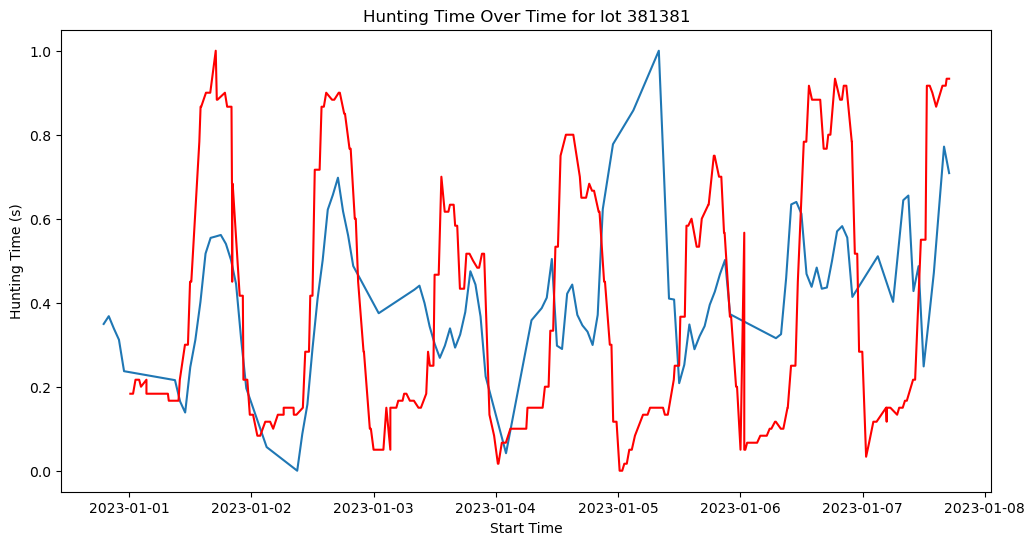

In [78]:
# plot a line plot of hunting mode over time from trips_gpd
hunting_df_lot = hunting_df[hunting_df['pk_lot'] == pk_lot].copy()
# trips_lot_gpd = trips_lot_gpd[trips_lot_gpd['start_time'] >= '2023-01-04 00:00:00-08:00']
hunting_df_lot = hunting_df_lot.sort_values('nearest_hour')

x = hunting_df_lot['nearest_hour']
# smooth the hunting time
y = hunting_df_lot['hunting_time'].rolling(window=4).mean()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.xlabel('Start Time')
plt.ylabel('Hunting Time (s)')
plt.title(f'Hunting Time Over Time for lot {pk_lot}')

z = lot_parking_occupancy['f_pct_occ']
z = (z - z.min()) / (z.max() - z.min())
lot_parking_occupancy = parking_occupancy[parking_occupancy['pk_lot'] == pk_lot].copy()
plt.plot(lot_parking_occupancy['dt_start_date'], z, color='red')
plt.show()


In [79]:
hunting_df_lot

,nearest_hour,pk_lot,num_trips,hunting_time
4,2022-12-31 16:00:00-08:00,381381,7,122.566286
10,2022-12-31 17:00:00-08:00,381381,29,159.245793
16,2022-12-31 18:00:00-08:00,381381,23,131.260870
22,2022-12-31 19:00:00-08:00,381381,13,125.307692
27,2022-12-31 20:00:00-08:00,381381,11,139.636364
...,...,...,...,...
600,2023-01-07 13:00:00-08:00,381381,46,204.643022
606,2023-01-07 14:00:00-08:00,381381,36,196.525806
612,2023-01-07 15:00:00-08:00,381381,42,239.670167
618,2023-01-07 16:00:00-08:00,381381,37,286.518649


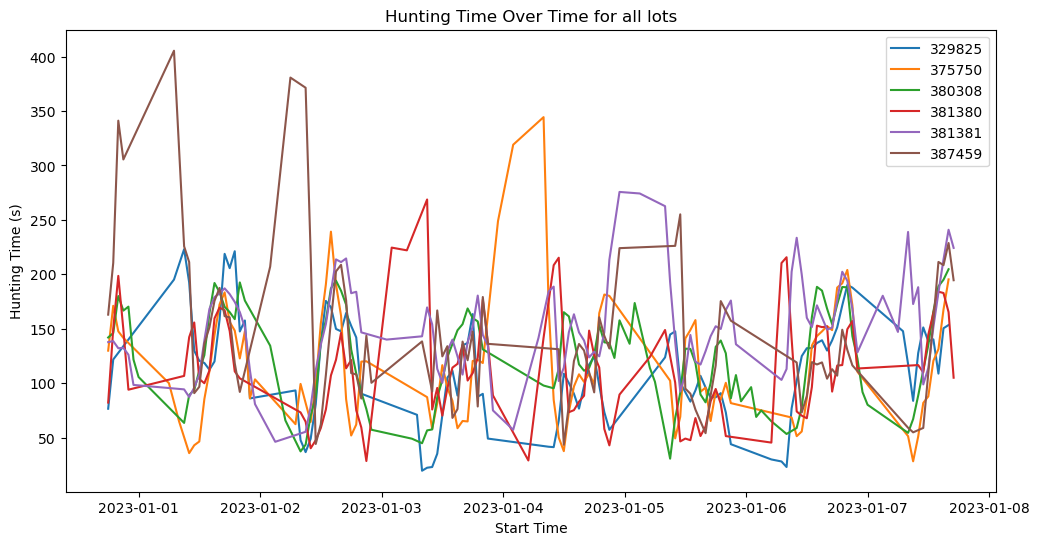

In [80]:
# plot a line plot of hunting time over time from trip_gpd grouped by pk_lot
grouped = hunting_df.groupby('pk_lot')
plt.figure(figsize=(12, 6))
for name, group in grouped:
    x = group['nearest_hour']
    y = group['hunting_time'].rolling(window=3).mean()
    plt.plot(x, y, label=name)
plt.xlabel('Start Time')
plt.ylabel('Hunting Time (s)')
plt.title('Hunting Time Over Time for all lots')
plt.legend()
plt.show()